In [ ]:
# TBD: create bash script
# To download kssl dataset
# pip install gdown (see cell below)
# cd /root
# python
# import gdown
# id = "1qh8isMQIzhArsj3RNWJe6g0lx_cs7iBG" or "1SzQZqpbJuK3iCqjJYabuEobbgPXm3cHT" for v2



# gdown.download(id=id)
# quit()
# tar -xvf kssl.tar.gz

# paperspace only
#!pip install gdown 
#!pip install --upgrade gdown

# paperspace only
#!pip install spanda

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from pathlib import Path
from fastai.vision.all import *
#from fastai.data.all import *
from tqdm import tqdm as tqdm

from sklearn.model_selection import train_test_split
import pandas as pd
import fastcore.all as fc
#from fastcore.basics import store_attr
from fastcore.foundation import *
from fastcore.xtras import *
from functools import partial

import timm

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torchvision import transforms as T

#from spanda.data.transforms import (SpectraBlock, AnalytesBlock, SpectraTfm, 
#                                    AnalytesTfm, SNVTfm, RandWAvgTfm, NormalizeTfm, LogTfm)

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

use_cuda = torch.cuda.is_available()
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
#device = 'cpu'

In [ ]:
def meet_criteria(src_dir):
    has_spectrum = len(L(fname for fname in src_dir.ls() if fname.name != 'target.csv')) > 0
    y_in_range = (pd.read_csv(src_dir / 'target.csv', index_col='analyte').loc['K'] > 0).value
    return has_spectrum and y_in_range

In [ ]:
paths = Path('../../_data/lucas-nirs').ls(); paths

(#21859) [Path('../../_data/lucas-nirs/28261972'),Path('../../_data/lucas-nirs/43443418'),Path('../../_data/lucas-nirs/42221892'),Path('../../_data/lucas-nirs/36742852'),Path('../../_data/lucas-nirs/45963284'),Path('../../_data/lucas-nirs/39082546'),Path('../../_data/lucas-nirs/54202132'),Path('../../_data/lucas-nirs/46821620'),Path('../../_data/lucas-nirs/33522030'),Path('../../_data/lucas-nirs/37362192')...]

In [ ]:
paths_clean = L([path for path in tqdm(paths) if meet_criteria(path)]); paths_clean

100%|████████████████████████████████████████████████████████| 21859/21859 [00:15<00:00, 1398.23it/s]


(#21779) [Path('../../_data/lucas-nirs/28261972'),Path('../../_data/lucas-nirs/43443418'),Path('../../_data/lucas-nirs/42221892'),Path('../../_data/lucas-nirs/36742852'),Path('../../_data/lucas-nirs/45963284'),Path('../../_data/lucas-nirs/39082546'),Path('../../_data/lucas-nirs/54202132'),Path('../../_data/lucas-nirs/46821620'),Path('../../_data/lucas-nirs/33522030'),Path('../../_data/lucas-nirs/37362192')...]

In [ ]:
def get_x(src_dir, index='wavelength'):
    fnames = L(fname for fname in src_dir.ls() if fname.name != 'target.csv')
    dfs = (pd.read_csv(fname, index_col=index) for fname in fnames)
    df = pd.concat(dfs, axis=1, ignore_index=False)
    #return torch.tensor(df.mean(axis=1).values, dtype=torch.float)[None,:]
    return torch.tensor(df.values, dtype=torch.float).T.to(device)

In [ ]:
get_x(Path('../../_data/lucas-nirs/28261972')).shape

torch.Size([2, 3440])

In [ ]:
def get_y(src_dir, index='analyte', analytes=None):
    df = pd.read_csv(src_dir / 'target.csv', index_col=index)
    if analytes:
        analytes = [analytes] if type(analytes) == 'str' else analytes
        df = df.loc[analytes]
    return torch.tensor(df.values, dtype=torch.float).to(device)

In [ ]:
get_y(Path('../../_data/lucas-nirs/28261972'), analytes='K')

tensor([265.5000])

In [ ]:
class AvgTfm:
    def __init__(self, weighted=False):
        self.weighted = weighted
        
    def __call__(self, x): 
        if self.weighted:
            return self._weights(len(x))@x
        else:
            return torch.mean(x, dim=0, keepdim=True)
    
    def _weights(self, n):
        weights = torch.rand(n)
        return (weights/weights.sum()).unsqueeze(dim=0).to(device)

In [ ]:
class GADFTfm:
    def __init__(self, neg=True):
        self.neg = neg
        
    def rescale(self, x):
        m, M = x.min(), x.max()
        return ((x - M) + (x - m)) / (M - m) if self.neg else (x - m) / (M - m)

    def __call__(self, x):
        X, I = self.rescale(x), torch.ones((1, x.shape[1])).to(device)
        K = torch.sqrt(I - torch.square(X))
        return K.t()@X - X.t()@K

In [ ]:
class To3DTfm:
    def __init__(self, n=3440):
        n_channel = n // 3
        self.edge_side = ceil(sqrt(n_channel))
        self.padding = 3*self.edge_side**2 - n - 1
        
    def __call__(self, x):
        x = F.pad(x, (1, self.padding), mode='constant')
        return x.view(3, self.edge_side, self.edge_side)

In [ ]:
class ResizeTfm:
    def __init__(self, size=256):
        self.size = size
        
    def __call__(self, x):
        return T.Resize(self.size)(x.unsqueeze(0))

In [ ]:
ResizeTfm()(GADFTfm()(get_x(Path('../../_data/lucas-nirs/28261972')))).shape

torch.Size([1, 256, 256])

In [ ]:
AvgTfm(weighted=True)(get_x(Path('../../_data/lucas-nirs/28261972')))

tensor([[0.4347, 0.4343, 0.4339,  ..., 0.3635, 0.3635, 0.3635]])

In [ ]:
transforms_x = T.Compose([GADFTfm(), ResizeTfm(224)])
#transforms_x = T.Compose([GADFTfm()])

In [ ]:
class NIRSDataset(Dataset):
    def __init__(self, src_dirs, get_x, get_y, transform=None, target_transform=None):
        #fc.store_attr()
        self.src_dirs = src_dirs
        self.transform = transform
        self.target_transform = target_transform
        self.get_x = get_x
        self.get_y = get_y

    def __len__(self):
        return len(self.src_dirs)

    def __getitem__(self, idx):
        x, y =  (getter(self.src_dirs[idx]) for getter in [self.get_x, self.get_y])
        if self.transform: 
            x = self.transform(x)
        if self.target_transform: 
            y = self.target_transform(y)
        return x, y

In [ ]:
paths_train, paths_valid = train_test_split(paths_clean, 
                                            test_size=0.2, 
                                            random_state=41)

In [ ]:
train_ds, valid_ds = [NIRSDataset(paths, 
                                  get_x=get_x,
                                  get_y=partial(get_y, analytes='K'),
                                  transform=transforms_x
                                 )
                      for paths in [paths_train, paths_valid]] 

In [ ]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    Dataloaders = namedtuple('Dataloader', ['train', 'valid'])
    return Dataloaders(
        DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
        DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [ ]:
# prefetch_factor=4
n_workers = 8
dls = get_dls(train_ds, valid_ds, bs=32, num_workers=n_workers)

In [ ]:
def dl_time_per_epoch(t, n=40000, bs=32):
    dl_time = t*n/(bs*60)
    print(f'about {dl_time:.3} min per epoch')

In [ ]:
durations = []
n_batches = 10
i = 0
for x, y in dls.train:
    if i > 0: 
        duration = time.time() - start
        print(f'{duration} s per batch')
        durations.append(duration)
        
    if i > n_batches: break
    start = time.time()
    i += 1
    
print(f'on average: {np.array(durations).mean():.3} s per batch')
dl_time_per_epoch(np.array(durations).mean())

0.024026155471801758 s per batch
0.0009772777557373047 s per batch
0.041091203689575195 s per batch
0.0004360675811767578 s per batch
0.03304409980773926 s per batch
0.0004191398620605469 s per batch
0.000453948974609375 s per batch
3.21966814994812 s per batch
0.1029350757598877 s per batch
0.0005018711090087891 s per batch
0.12560677528381348 s per batch
on average: 0.323 s per batch
about 6.72 min per epoch


In [ ]:
# 1 cpu -> 18.4 min
# 8 cpu -> 6.5 min

In [ ]:
# loading: 2.62
# loading + gadf: 14.6 min
# loading + gadf + resize: 22.8 min

# So even with 6 cores, it takes about 2 mins loading for one epoch

In [ ]:
%%time
next(iter(dls.train))[0].shape

In [ ]:
import matplotlib
#matplotlib.use('Agg')
matplotlib.use('ipympl')

ValueError: 'ipympl' is not a valid value for backend; supported values are ['GTK3Agg', 'GTK3Cairo', 'GTK4Agg', 'GTK4Cairo', 'MacOSX', 'nbAgg', 'QtAgg', 'QtCairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']

In [ ]:
def to_png(x):
    plt.imshow(x, cmap='Spectral', 
           origin='upper')

    plt.axis('off')
    plt.savefig('test1.png', dpi=70, format='png', bbox_inches='tight', pad_inches = 0);

In [ ]:
%%time
to_png(next(iter(dls.train))[0][1].squeeze().cpu())

CPU times: user 3.04 s, sys: 1.43 s, total: 4.48 s
Wall time: 855 ms


In [ ]:
40000 / 60 / 60

11.11111111111111

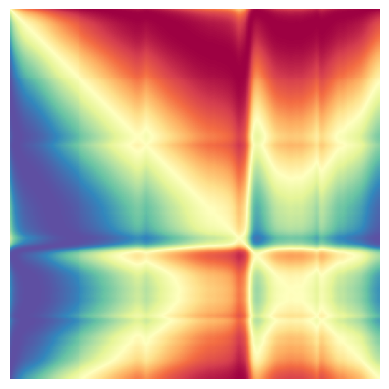

In [ ]:
plt.imshow(next(iter(dls.train))[0][1].squeeze().cpu(), cmap='Spectral', 
           origin='upper')

plt.axis('off')
plt.savefig('test1.png', dpi=70, format='png', bbox_inches='tight', pad_inches = 0)

In [ ]:
from fastai.data.external import *

In [ ]:
im = Image.open('test1.png')

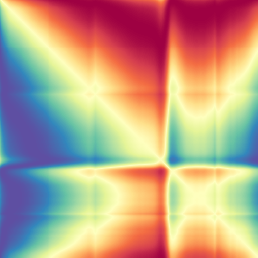

In [ ]:
im

In [ ]:
# to PIL image?
gadf_tensor = next(iter(dls.train))[0][0]; gadf_tensor.shape

torch.Size([1, 224, 224])

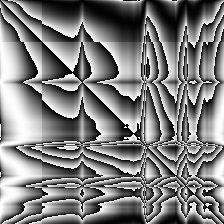

In [ ]:
img = T.ToPILImage()(gadf_tensor); img

In [ ]:
gadf_tensor

tensor([[[ 0.0000, -0.3079, -0.5023,  ..., -1.5853, -1.4728, -1.3944],
         [ 0.3079,  0.0000, -0.1984,  ..., -1.3801, -1.2481, -1.1582],
         [ 0.5023,  0.1984,  0.0000,  ..., -1.2299, -1.0872, -0.9910],
         ...,
         [ 1.5853,  1.3801,  1.2299,  ...,  0.0000,  0.1750,  0.2869],
         [ 1.4728,  1.2481,  1.0872,  ..., -0.1750,  0.0000,  0.1126],
         [ 1.3944,  1.1582,  0.9910,  ..., -0.2869, -0.1126,  0.0000]]])

In [ ]:
torch.save(gadf_tensor, 'tensor.pt')

In [ ]:
T.PILToTensor()(img)

tensor([[[  0,   0,   0,  ...,   0,   0,   0],
         [ 84,   0,   0,  ...,   0,   0,   0],
         [138,  55,   0,  ...,   0,   0,   0],
         ...,
         [255, 255, 255,  ...,   0,  17,  27],
         [255, 255, 255,  ...,   0,   0,   9],
         [255, 255, 255,  ...,   0,   0,   0]]], dtype=torch.uint8)

In [ ]:
# Only samples with spectra
path = Path('../../_data/lucas-nirs')
paths = [p for p in nb_tqdm(path.ls()) if len(p.ls()) > 1]; print(f'n samples: {len(paths)}')

100%|███████████████████████████████████████████████████████| 21859/21859 [00:01<00:00, 21815.79it/s]

n samples: 21782


In [ ]:
# Only strictly positive measurements (
paths = [p for p in tqdm(paths) if AnalytesTfm(analytes=['K'])(get_target(p)) !=0] 
print(f'n samples: {len(paths)}')

100%|████████████████████████████████████████████████████████| 21782/21782 [00:16<00:00, 1315.04it/s]

n samples: 21779


In [ ]:
# Stats

## Spectra
#Xs = []
#n = 0
#for p in paths:
#    Xs.append(SpectraTfm()(get_target(p)))
#    n += 1 
#    if n > 1000: break
#print(f'X mean: {torch.mean(torch.concat(Xs))}, X Std: {torch.std(torch.concat(Xs))}');

In [ ]:
ys = []
n = 0
for p in paths:
    ys.append(AnalytesTfm(analytes=['K'])(get_target(p)))
    n += 1 
    if n > 1000: break

In [ ]:
torch.concat(ys).min()

Analytes(1.3000)

In [ ]:
torch.concat(ys).max()

Analytes(10030.9004)

In [ ]:
torch.concat(ys).mean()

Analytes(211.0901)

In [ ]:
def lucas2kssl(y):
    m_k = 39.0983
    return y/(m_k*10)

In [ ]:
lucas2kssl(10030.9004)

25.655592186872575

In [ ]:
211 / 390.9

0.539779994883602

(array([  1.,   1.,   2.,   0.,   1.,  15.,  39.,  66., 107., 163., 206.,
        180., 124.,  67.,  22.,   3.,   3.,   0.,   0.,   1.]),
 array([0.11394334, 0.30831316, 0.50268298, 0.69705284, 0.89142263,
        1.08579254, 1.28016233, 1.47453213, 1.66890192, 1.86327183,
        2.05764151, 2.25201154, 2.44638133, 2.64075112, 2.83512092,
        3.02949071, 3.2238605 , 3.41823053, 3.61260033, 3.80697012,
        4.00133991]),
 <BarContainer object of 20 artists>)

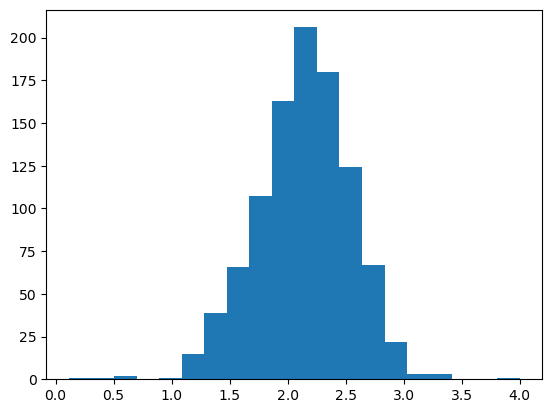

In [ ]:
import matplotlib.pyplot as plt

plt.hist(torch.log10(torch.concat(ys)), bins=20)
#plt.xscale('log') 

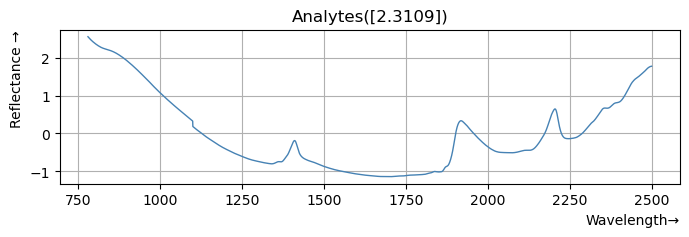

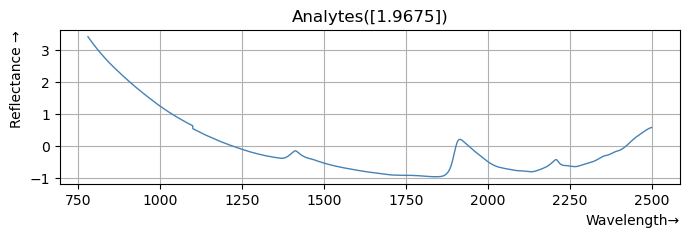

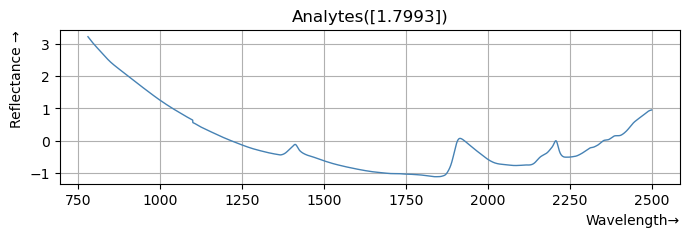

In [ ]:
n_smp = None # None for all

#get_spectra = lambda o: L(fname for fname in o.ls() if re.match('\d+_\d', fname.name))
get_spectra = lambda o: L(f for f in o.ls() if not re.match('target', f.name))
get_target = lambda o: [f for f in o.ls() if re.match('target', f.name)][0]

dblock = DataBlock(blocks=(SpectraBlock, AnalytesBlock(analytes=['K'])),
                   get_x=get_spectra,
                   get_y=get_target,
                   splitter=RandomSplitter(),
                   item_tfms=[RandWAvgTfm(), SNVTfm(),
                              LogTfm()])

dls = dblock.dataloaders(paths[:n_smp], bs=3)
dls.show_batch()

In [ ]:
device

'mps'

In [ ]:
# Create Learner
model = xresnet18(ndim=1, c_in=1, ks=3, n_out=1).to(device)
learn = Learner(get_dls(train_ds, valid_ds, bs=32), model, loss_func=MSELossFlat(), metrics=R2Score())

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,r2_score,time


KeyboardInterrupt: 

In [ ]:
# 2D
learn = vision_learner(dls, 'resnet18', loss_func=MSELossFlat(), metrics=R2Score(), n_out=1, n_in=1)